### Preliminaries

In [1]:
# Autoreload all modules when changes are saved. 
%reload_ext autoreload
%autoreload 2  

# Show all figures inline.  
%matplotlib inline

# Add olfaction-prediction to the Python path.  
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import generic utility modules I wrote to load the data from the tab-delimited text files and to score predictions.  
from opc_python.utils import loading, scoring

# Import the modules I wrote for actually shaping and fitting the data to the model.  
from opc_python.gerkin import dream,fit2

In [3]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [4]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [5]:
num_descriptors = len(perceptual_headers[6:])
num_subjects = 49
print('There are %d different perceptual descriptors and %d different subjects' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [76]:
# Load the molecular descriptors data.  
molecular_headers, molecular_data = loading.load_molecular_data()
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [7]:
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
print("We have perceptual data for %d unique molecules" % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

We have perceptual data for 338 unique molecules
138 are left out for testing in the competition; half of these (69) are used for the leaderboard.


In [8]:
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)" % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules)


In [9]:
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
DATA = '/Users/rgerkin/Dropbox/science/olfaction-prediction/data/'
import pandas

In [10]:
episuite = pandas.read_table('%s/DREAM_episuite_descriptors.txt' % DATA)
episuite.iloc[:,49] = 1*(episuite.iloc[:,49]=='YES ')
episuite.iloc[:,49]
episuite = episuite.iloc[:,2:].as_matrix()
episuite.shape

(476, 62)

In [42]:
verbal = pandas.read_table('%s/name_features.txt' % DATA, sep='\t', header=None)
verbal = verbal.as_matrix()[:,1:]
verbal.shape

(476, 11786)

In [12]:
morgan = pandas.read_csv('%s/morgan_sim.csv' % DATA)
morgan = morgan.as_matrix()[:,1:]
morgan.shape

(476, 2437)

In [13]:
with open('%s/derived/nspdk_r3_d4_unaug.svm' % DATA) as f:
    nspdk_dict = {}
    i = 0
    while True:
        x = f.readline()
        if(len(x)):
            key_vals = x.split(' ')[1:]
            for key_val in key_vals:
                key,val = key_val.split(':')
                if key in nspdk_dict:
                    nspdk_dict[key][all_CIDs[i]] = val
                else:
                    nspdk_dict[key] = {all_CIDs[i]:val}
            i+=1
            if i == len(all_CIDs):
                break
        else:
            break
nspdk_dict = {key:value for key,value in nspdk_dict.items() if len(value)>1}

In [14]:
nspdk = np.zeros((len(all_CIDs),len(nspdk_dict)))
for j,(feature,facts) in enumerate(nspdk_dict.items()):
    for CID,value in facts.items():
        i = all_CIDs.index(CID)
        nspdk[i,j] = value
nspdk.shape

(476, 6163)

In [52]:
nspdk_gramian = pandas.read_table('%s/derived/nspdk_r3_d4_unaug_gramian.mtx' % DATA, delimiter=' ', header=None)
nspdk_gramian = nspdk_gramian.as_matrix()[:len(all_CIDs),:]
nspdk_gramian.shape

(476, 2437)

In [78]:
molecular_data_types = ['dragon','dragon+episuite','dragon+verbal','dragon+morgan',
                                                          'dragon+nspdk','dragon+nspdk_gramian','dragon+all']
molecular_data = {mdt:molecular_data.copy() for mdt in molecular_data_types}
for i,line in enumerate(molecular_data['dragon']):
    CID = int(line[0])
    index = all_CIDs.index(CID)
    molecular_data['dragon+episuite'][i] = line + list(episuite[index])
    molecular_data['dragon+verbal'][i] = line + list(verbal[index])
    molecular_data['dragon+morgan'][i] = line + list(morgan[index])
    molecular_data['dragon+nspdk'][i] = line + list(nspdk[index])
    molecular_data['dragon+nspdk_gramian'][i] = line + list(nspdk_gramian[index])
    molecular_data['dragon+all'][i] = line + list(episuite[index]) + list(morgan[index]) + list(nspdk[index]) + list(nspdk_gramian[index])

### Create Molecular Matrix

In [79]:
X_training = {mdt:None for mdt in molecular_data_types}
X_leaderboard_other = {mdt:None for mdt in molecular_data_types}
X_leaderboard_int = {mdt:None for mdt in molecular_data_types}
for mdt in molecular_data_types:
    X_training[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"training")
    X_leaderboard_other[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
    X_leaderboard_int[mdt],good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
    if mdt == 'dragon':
        X_testset_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
        X_testset_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
        X_all,good1,good2,means,stds,imputer = dream.make_X(molecular_data[mdt],['training','leaderboard'],good1=good1,good2=good2,means=means,stds=stds)

There are now 676 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (676x3033) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors
There are now 814 molecular vectors of length 4871, one for each molecule and dilution
The X matrix now has shape (814x3033) molecules by non-N

In [57]:
Y_training_imp,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')
Y_training_mask,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one

In [58]:
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [59]:
Y_leaderboard_noimpute,_ = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer=None)

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [60]:
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


In [61]:
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


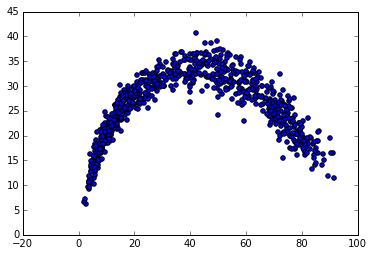

In [62]:
plt.scatter(Y_all_mask['mean_std'][:,0],Y_all_mask['mean_std'][:,21])

### Data preparation

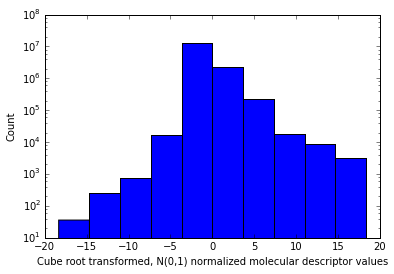

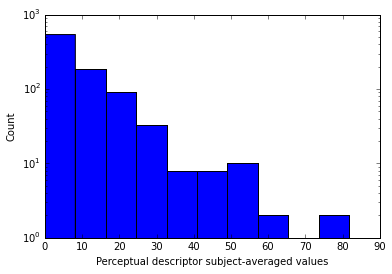

In [63]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_training['dragon+all'].ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(Y_training_imp['mean_std'][:21].ravel())
plt.yscale('log')
plt.ylabel('Count')
_ = plt.xlabel('Perceptual descriptor subject-averaged values')

## Fitting and Generating Submission Files

In [64]:
write = True # Set to True to actually generate the prediction files.  
n_estimators = 1000 # Set this to a high number (e.g. 1000) to get a good fit.  

# Best parameters, determined independently.  
max_features = {'int':{'mean':None,'sigma':None},
                'ple':{'mean':100,'sigma':None},
                'dec':{'mean':500,'sigma':500}}
min_samples_leaf = {'int':{'mean':1,'sigma':4},
                'ple':{'mean':1,'sigma':1},
                'dec':{'mean':1,'sigma':1}}
max_depth = {'int':{'mean':None,'sigma':2},
                'ple':{'mean':10,'sigma':10},
                'dec':{'mean':10,'sigma':10}}
et = {'int':{'mean':True,'sigma':True},
                'ple':{'mean':False,'sigma':False},
                'dec':{'mean':False,'sigma':False}}
#et['int'] = {'mean':False,'sigma':False} # Uncomment to get a correct score estimate, or leave commented to get best fit.  
use_mask = {'int':{'mean':False,'sigma':True},
                'ple':{'mean':False,'sigma':True},
                'dec':{'mean':False,'sigma':True}}

In [80]:
# Fit training data.  Ignoring warning that arises if too few trees are used.  
#rfcs_leaderboard = {mdt:None for mdt in molecular_data_types}
for mdt in molecular_data_types:
    print(mdt)
    if mdt != 'dragon+all':
        continue
    rfcs_leaderboard[mdt],score,rs = fit2.rfc_final(X_training[mdt],Y_training_imp['mean_std'],Y_training_mask['mean_std'],
                            max_features,min_samples_leaf,max_depth,et,use_mask,
                            n_estimators=n_estimators)

dragon
dragon+episuite
dragon+verbal
dragon+morgan
dragon+nspdk
dragon+nspdk_gramian
dragon+all
For subchallenge 2:
	Score = 8.10
	int_mean = 1.000
	int_sigma = 0.152
	ple_mean = 0.662
	ple_sigma = 0.278
	dec_mean = 0.476
	dec_sigma = 0.375


In [81]:
for mdt in molecular_data_types:
    print(mdt)
    loading.make_prediction_files(rfcs_leaderboard[mdt],X_leaderboard_int[mdt],X_leaderboard_other[mdt],
                                  'leaderboard_%s' % mdt,2,Y_test=Y_leaderboard_noimpute,write=False)

dragon
Score: 8.614029; rs = 0.658,0.517,0.522,0.385,0.244,0.479
dragon+episuite
Score: 8.716942; rs = 0.665,0.509,0.535,0.372,0.238,0.487
dragon+verbal
Score: 8.299890; rs = 0.662,0.498,0.506,0.260,0.274,0.468
dragon+morgan
Score: 8.746169; rs = 0.650,0.532,0.535,0.330,0.272,0.492
dragon+nspdk
Score: 9.138397; rs = 0.684,0.577,0.551,0.447,0.256,0.500
dragon+nspdk_gramian
Score: 8.953301; rs = 0.633,0.571,0.543,0.429,0.233,0.499
dragon+all
Score: 9.055417; rs = 0.648,0.573,0.555,0.371,0.273,0.504


In [46]:
rs_ = [[0.658,0.517,0.522,0.385,0.244,0.479],[0.665,0.509,0.535,0.372,0.238,0.487],[0.662,0.498,0.506,0.260,0.274,0.468],
[0.650,0.532,0.535,0.330,0.272,0.492],[0.684,0.577,0.551,0.447,0.256,0.500],[0.655,0.551,0.535,0.269,0.311,0.486]]
for i,challenge in enumerate(rs_):
    print(molecular_data_types[i]+'\t'.join(str(x) for x in challenge))
        

dragon0.658	0.517	0.522	0.385	0.244	0.479
dragon+episuite0.665	0.509	0.535	0.372	0.238	0.487
dragon+verbal0.662	0.498	0.506	0.26	0.274	0.468
dragon+morgan0.65	0.532	0.535	0.33	0.272	0.492
dragon+nspdk0.684	0.577	0.551	0.447	0.256	0.5
dragon+all0.655	0.551	0.535	0.269	0.311	0.486


In [23]:
rfcs,score,rs = fit2.rfc_final(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                            max_features,min_samples_leaf,max_depth,et,use_mask,
                            n_estimators=n_estimators)

For subchallenge 2:
	Score = 2.83
	int_mean = 1.000
	int_sigma = 0.126
	ple_mean = 0.009
	ple_sigma = -0.010
	dec_mean = 0.133
	dec_sigma = 0.072


In [24]:
loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',2,write=False)

{'mean_std': array([[ 33.26530612,  44.62244898,   2.12244898, ...,   9.93389033,
          10.11045229,  21.72142009],
        [ 12.95918367,  48.15306122,   0.91836735, ...,   7.59583474,
          18.41829388,  22.26213039],
        [ 21.16326531,  44.62244898,   8.12244898, ...,   4.7887756 ,
           8.37787436,  24.78012562],
        ..., 
        [ 39.53061224,  59.50204082,   3.82780612, ...,  12.27196668,
          22.87507041,  19.62084018],
        [ 18.3877551 ,  57.82653061,   1.42212675, ...,   8.39165909,
          14.20939341,  23.09079336],
        [ 29.08163265,  49.21836735,   3.95918367, ...,  11.30602357,
          31.18954828,  22.55003619]]), 'subject': {}}